<a href="https://colab.research.google.com/github/MinhQuan0000/MV_final/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from google.colab import drive
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from google.colab.patches import cv2_imshow
from tensorflow.keras.regularizers import l2
drive.mount('/content/drive')


Mounted at /content/drive


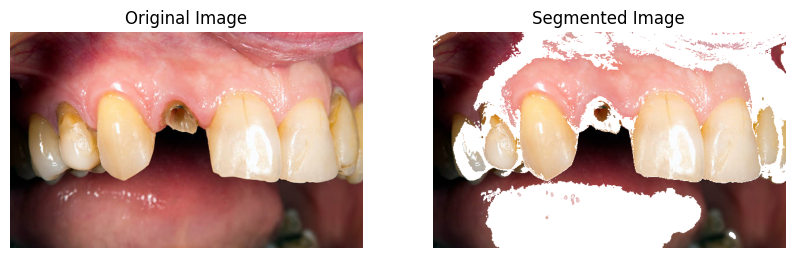

In [2]:
def segment_color_image(img_OpenCV, threshold=70):
    # Create an image to store the segmentation result
    SegmentationIMG = Image.new("RGB", (img_OpenCV.shape[1], img_OpenCV.shape[0]))
    # Get image dimensions
    Width, Height = img_OpenCV.shape[1], img_OpenCV.shape[0]
    # Initialize cumulative values for average color
    aR_TB = 0
    aG_TB = 0
    aB_TB = 0
    # Initialize SIZE
    Size = Width * Height
    # Calculate average pixel value for the entire image
    for x in range(Width):
        for y in range(Height):
            pixel_value = img_OpenCV[y, x]
            aR_TB += pixel_value[0]
            aG_TB += pixel_value[1]
            aB_TB += pixel_value[2]

    # Calculate the average color values
    aR_TB /= Size
    aG_TB /= Size
    aB_TB /= Size

    # Loop through all pixels in the image
    for a in range(Width):
        for b in range(Height):
            pixel_value = img_OpenCV[b, a]
            # Calculate Euclidean Distance D(z, a)
            D = np.sqrt((pixel_value[0] - aR_TB)**2 + (pixel_value[1] - aG_TB)**2 + (pixel_value[2] - aB_TB)**2)
            # Compare with the threshold to determine if z(x, y) is background or object
            if D <= threshold:
                SegmentationIMG.putpixel((a, b), (255, 255, 255))  # White pixel
            else:
                SegmentationIMG.putpixel((a, b), (int(pixel_value[2]), int(pixel_value[1]), int(pixel_value[0])))

    # Convert the segmentation result from PIL to OpenCV for display
    Segmentation = np.array(SegmentationIMG)
    return Segmentation

def display_images(original_image, segmented_image):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Segmented Image
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')
    plt.axis('off')

    plt.show()

# Example usage
image_path1 = '/content/drive/MyDrive/XLA_S/Training/caries/100.jpg'
img_OpenCV = cv2.imread(image_path1, cv2.IMREAD_COLOR)
segmented_image = segment_color_image(img_OpenCV)
display_images(cv2.cvtColor(img_OpenCV, cv2.COLOR_BGR2RGB), segmented_image)


In [ ]:
def save_segmented_images(directory_path, output_directory):
    image_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path)]
    for img_path in image_paths:
        #print(f"Processing image: {img_path}")
        img_OpenCV = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        segmented_image = segment_color_image(img_OpenCV)

        # Get the name of the last folder in the path
        folder_name = os.path.basename(os.path.dirname(img_path))
        # Save the segmented image to the corresponding output folder
        output_path = os.path.join(output_directory, folder_name, os.path.basename(img_path))
        cv2.imwrite(output_path, cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))

# Set paths
train_dir = '/content/drive/MyDrive/XLA_S/Training'
output_segmented_dir = '/content/drive/MyDrive/XLA_S/Segmented'

# Create destination folders to save segmented images
os.makedirs(os.path.join(output_segmented_dir, 'Caries'), exist_ok=True)
os.makedirs(os.path.join(output_segmented_dir, 'No Caries'), exist_ok=True)

# Process, save, and segment caries images in the training directory
caries_train_dir = os.path.join(train_dir, 'caries')
save_segmented_images(caries_train_dir, os.path.join(output_segmented_dir, 'Caries'))

# Process, save, and segment no caries images in the training directory
no_caries_train_dir = os.path.join(train_dir, 'No Caries')
save_segmented_images(no_caries_train_dir, os.path.join(output_segmented_dir, 'No Caries'))



In [ ]:
# Set paths
train_dir = '/content/drive/MyDrive/XLA_S/Segmented'
batch_size = 64
input_shape = (2000, 2000, 3)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_dir ='/content/drive/MyDrive/XLA_S/Test'
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)




Found 257 images belonging to 3 classes.
Found 32 images belonging to 2 classes.
Epoch 1/100
9/9 [==============================] - 7s 611ms/step - loss: 20.2509 - accuracy: 0.8093 - val_loss: 4.2051 - val_accuracy: 0.8750
Epoch 2/100
9/9 [==============================] - 4s 438ms/step - loss: 11.4493 - accuracy: 0.9416 - val_loss: 17.8883 - val_accuracy: 0.8750
Epoch 3/100
9/9 [==============================] - 6s 640ms/step - loss: 8.7271 - accuracy: 0.9416 - val_loss: 5.8084 - val_accuracy: 0.8750
Epoch 4/100
9/9 [==============================] - 4s 436ms/step - loss: 3.8625 - accuracy: 0.8210 - val_loss: 3.4191 - val_accuracy: 0.8750
Epoch 5/100
9/9 [==============================] - 5s 604ms/step - loss: 3.2218 - accuracy: 0.9416 - val_loss: 2.8529 - val_accuracy: 0.8750
Epoch 6/100
9/9 [==============================] - 4s 436ms/step - loss: 2.5186 - accuracy: 0.9416 - val_loss: 2.3473 - val_accuracy: 0.8750
Epoch 7/100
9/9 [==============================] - 5s 593ms/step - los

In [ ]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.2f}")

1/1 [==============================] - 0s 206ms/step - loss: 0.6074 - accuracy: 0.8750
Test accuracy: 0.88


In [ ]:
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.round(predictions)

1/1 [==============================] - 0s 229ms/step


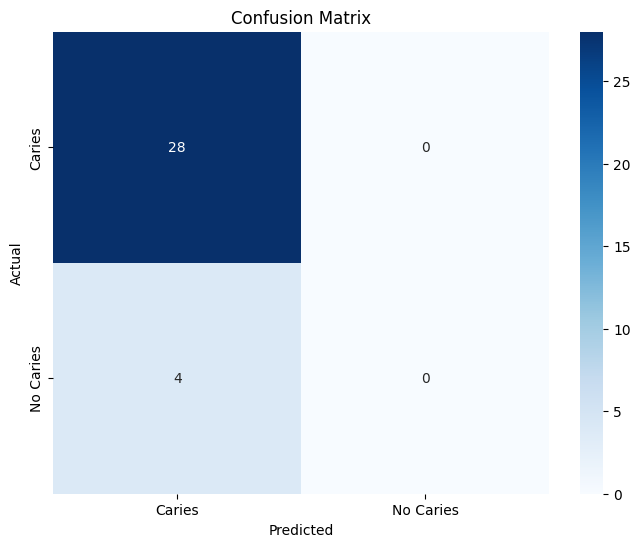

              precision    recall  f1-score   support

      Caries       0.88      1.00      0.93        28
   No Caries       0.00      0.00      0.00         4

    accuracy                           0.88        32
   macro avg       0.44      0.50      0.47        32
weighted avg       0.77      0.88      0.82        32



In [ ]:
# Suppress UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, y_pred, target_names=class_names))

# Remove the filter after using
warnings.filterwarnings("default", category=UndefinedMetricWarning)

Text(0.5, 1.0, 'Training and Validation Accuracy')

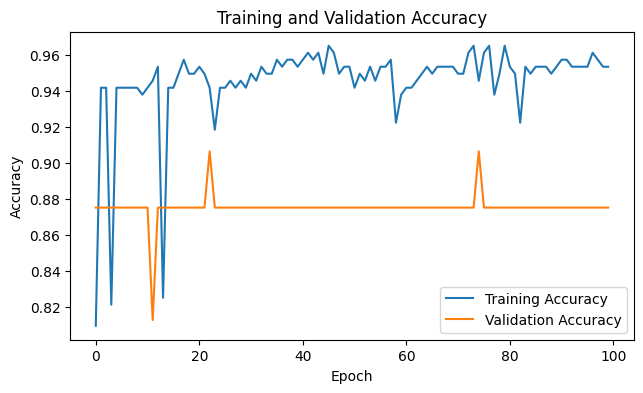

In [ ]:
# Plot learning curves
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

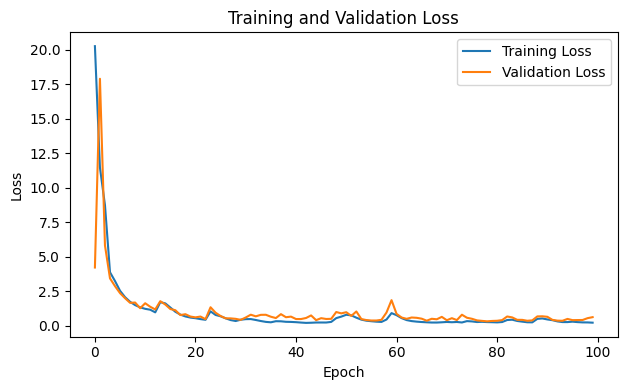

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

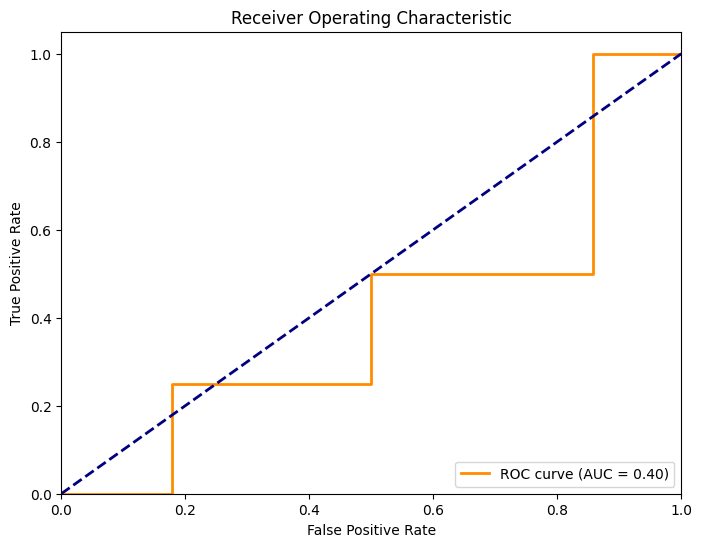

In [ ]:
# Visualize ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 67ms/step


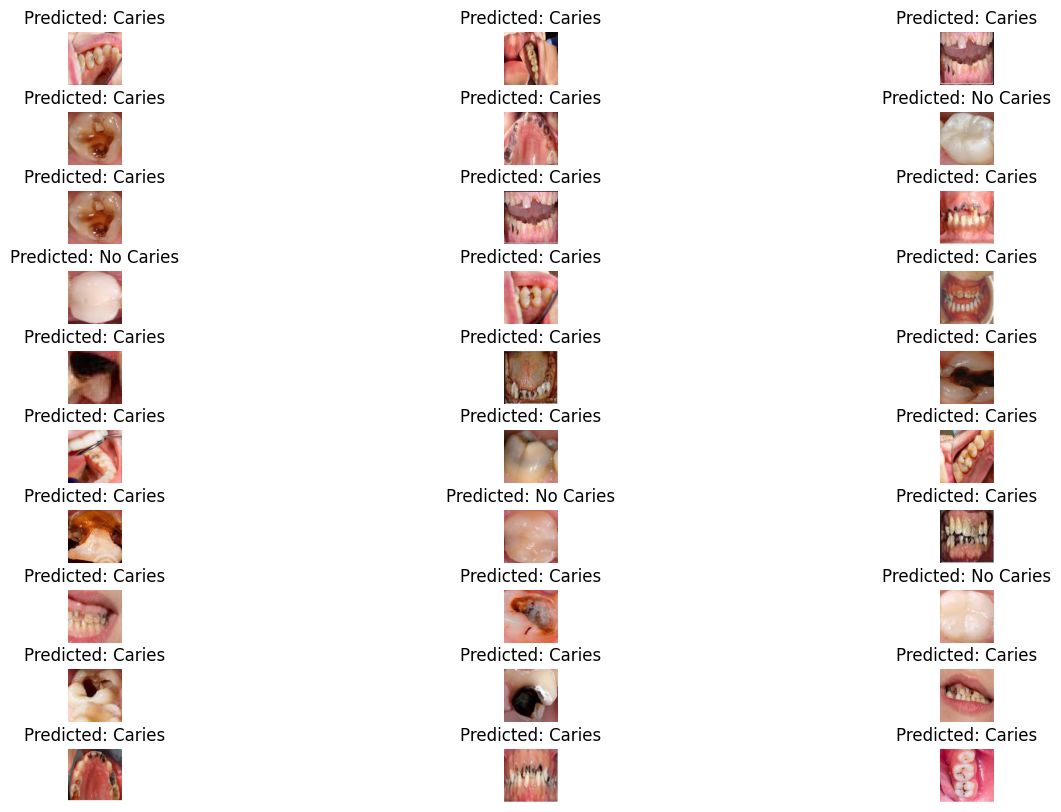

In [ ]:
# Load a few test images and predict their labels
num_images_to_predict = 30  # Change this to the number of images you want to predict

# Get a few test images and their true labels
test_images, true_labels = next(test_generator)

# Predict labels for the test images
predicted_labels = model.predict(test_images)

# Convert predicted labels to binary (0 or 1)
predicted_labels = np.round(predicted_labels)

# Define class names
class_names = ['Caries', 'No Caries']

# Define the number of rows and columns for subplots
num_rows = 10
num_cols = 3

# Display the test images along with their predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {class_names[int(true_labels[i])]}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots
plt.show()

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/XLA_S/Segmentation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
